In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pose_tensorflow
# from pose_tensorflow.util import visualize
# import matplotlib.pyplot as plt
from skimage.transform import resize as imresize
from imageio import imread, imwrite
from pose_tensorflow.draw import draw_annotations, find_coords
import numpy as np
from PIL import Image

class Side:
    Left = 1                    # yellow
    Right = 0                   # green

def make_smaller_png(img_file, output_file, max_dim=640):
    image = imread(image_file)
    factor = max(image.shape) // max_dim
    smaller_image = imresize(image, (image.shape[0] // factor, image.shape[1] // factor))
    imwrite(output_file, smaller_image)

def coords(image, pose, name, side):
    for r in results:
        if r["name"] == name and r["side"] == side:
            return r["x"], r["y"]
    return None

def euclidean_distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def compute_angle(p1, p2, p3):
    """
    We'll use the cosine rule
    c^2 = a^2 + b^2 - 2ab cos C
    
    We want the angle between (p1, p2) and (p2, p3)

    c = p1-p3
    a = p1-p2
    b = p2-p3

    """
    a = euclidean_distance(p1, p2)
    b = euclidean_distance(p2, p3)
    c = euclidean_distance(p1, p3)
    return round(np.degrees(np.arccos((a**2 + b**2 - c**2)/(2 * a * b))), 1)

def joint_angle(pose, j1, j2, j3, w, h):
    p1 = find_coords(pose, *j1, w, h)
    p2 = find_coords(pose, *j2, w, h)
    p3 = find_coords(pose, *j3, w, h)
    return compute_angle(p1, p2, p3)
    
def angle_to_vertical(pose, j1, j2, w, h):
    """
    finds a point on the 'y-axis' and computes the angle to it

    (?=x1,y2)
    *    * (p2 = x2, y2)
    |   /
    |  /
    | / 
    |/
    * (p1 = x1, y1)


    * (p1 = x1, y1)
    |\
    | \
    |  \
    |   \
    *    * (p2 = x2, y2)
    (?=x1,y2)

    # this can also be made more deterministic by computing x1, y1 + 100 etc.

    """
    p1 = x1, y1 = find_coords(pose, *j1, w, h)
    p2 = x2, y2 = find_coords(pose, *j2, w, h)
    p3 = (x1, y2)
    return compute_angle(p3, p1, p2)

def process_and_draw(image_file, side=Side.Left):
    im = Image.open(image_file)
    width, height = im.size
    pose = pose_tensorflow.process_single_image(image_file)
    esh_angle = joint_angle(pose, ('elbow', side), ('shoulder', side), ('hip', side), width, height)
    ves_angle = angle_to_vertical(pose, ('shoulder', side), ('elbow', side), width, height)
    side_name = 'left' if side == Side.Left else 'right'
    print(f"[{side_name}] E-S-H={esh_angle}, V-S-E={ves_angle} / {180-ves_angle}")
    return draw_annotations(image_file, pose, confidence_threshold=0.75)    


    

In [24]:
#!fd '.*?\.(png|jpg)' /home/venky/Downloads --changed-within 3w

W0706 18:47:51.204851 139739964016448 deprecation_wrapper.py:119] From /home/venky/dev/pose-tensorflow/pose_tensorflow/nnet/predict.py:9: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



/home/venky/Downloads/shflx2.jpg


W0706 18:47:54.773144 139739964016448 deprecation_wrapper.py:119] From /home/venky/dev/pose-tensorflow/pose_tensorflow/nnet/pose_net.py:66: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



W0706 18:47:55.328782 139739964016448 deprecation_wrapper.py:119] From /home/venky/dev/pose-tensorflow/pose_tensorflow/nnet/predict.py:13: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



W0706 18:47:55.689891 139739964016448 deprecation_wrapper.py:119] From /home/venky/dev/pose-tensorflow/pose_tensorflow/nnet/predict.py:15: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



W0706 18:47:56.044107 139739964016448 deprecation_wrapper.py:119] From /home/venky/dev/pose-tensorflow/pose_tensorflow/nnet/predict.py:17: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.



W0706 18:47:57.337106 139739964016448 deprecation_wrapper.py:119] From /home/venky/dev/pose-tensorflow/pose_tensorflow/nnet/predict.py:18: The name tf.local_variables_initializer is deprecated. Please use tf.compat.v1.local_variables_initializer instead.



W0706 18:47:57.488869 139739964016448 deprecation.py:323] From /home/venky/dev/miniconda3/envs/pose/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


[right] E-S-H=129.1, V-S-E=37.0 / 143.0


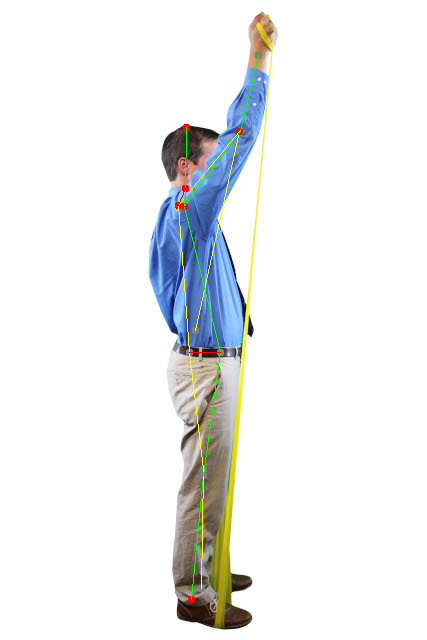

/home/venky/Downloads/Standing-Shoulder-Flexion-1.png


[left] E-S-H=89.7, V-S-E=89.5 / 90.5


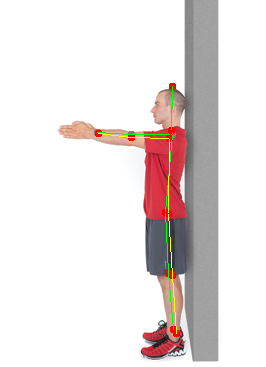

/home/venky/Downloads/Standing-Shoulder-Flexion-2.png


[left] E-S-H=169.8, V-S-E=4.3 / 175.7


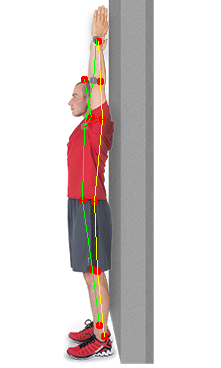

/home/venky/Downloads/17270394_760838637404334_83232299_n_copy_large-1.png


[right] E-S-H=76.9, V-S-E=84.8 / 95.2


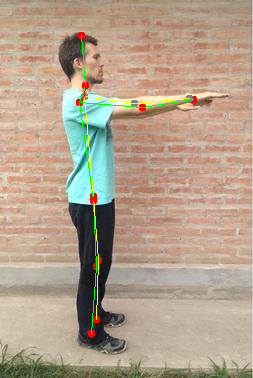

/home/venky/Downloads/1361.jpg


[left] E-S-H=57.0, V-S-E=61.9 / 118.1


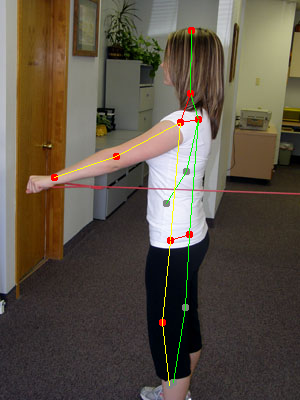

/home/venky/Downloads/maxresdefault-1.jpg


[right] E-S-H=17.1, V-S-E=6.4 / 173.6


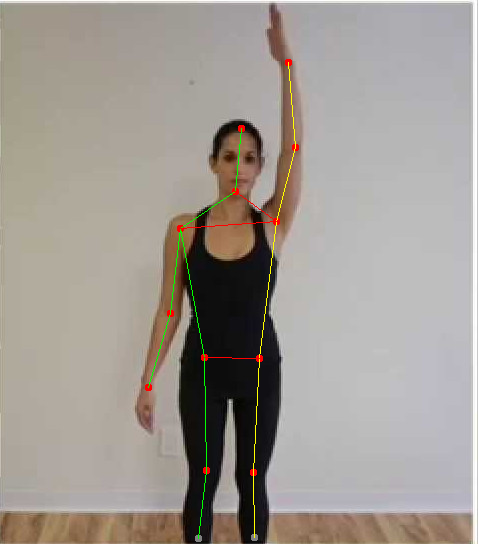

/home/venky/Downloads/maxresdefault-1.jpg


[left] E-S-H=172.7, V-S-E=14.4 / 165.6


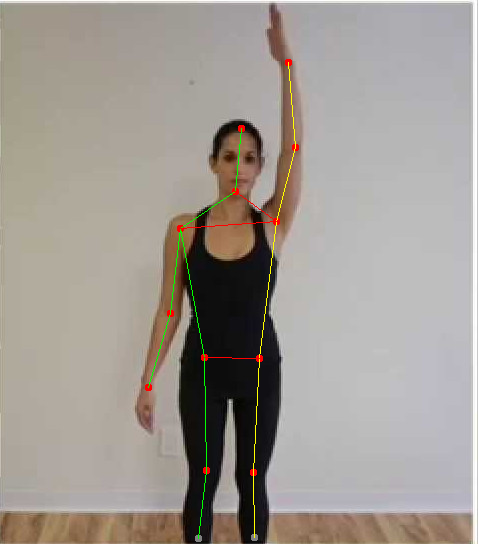

/home/venky/Downloads/maxresdefault-2.jpg


[left] E-S-H=146.6, V-S-E=33.1 / 146.9


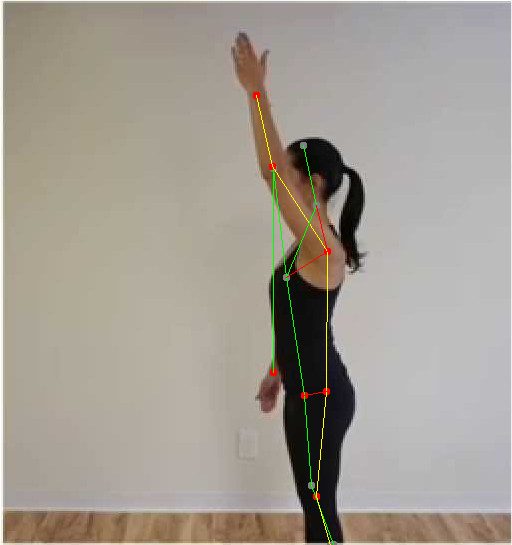

In [2]:
images = [
    ("/home/venky/Downloads/shflx2.jpg", Side.Right),
    ("/home/venky/Downloads/Standing-Shoulder-Flexion-1.png", Side.Left),
    ("/home/venky/Downloads/Standing-Shoulder-Flexion-2.png", Side.Left),
    ("/home/venky/Downloads/17270394_760838637404334_83232299_n_copy_large-1.png", Side.Right),
    # this doesn't work
    #("/home/venky/Downloads/ActiveShoulderFlexionSH.jpg", Side.Right),
    ("/home/venky/Downloads/1361.jpg", Side.Left),
    ("/home/venky/Downloads/maxresdefault-1.jpg", Side.Right),
    ("/home/venky/Downloads/maxresdefault-1.jpg", Side.Left),
    ("/home/venky/Downloads/maxresdefault-2.jpg", Side.Left),
]
for im,side in images:
    print(im)
    process_and_draw(im, side=side)